# Teste de Classificadores com ajuste de peso e modelos de arvore com up/downsampling 

O objetivo é testar os modelos XGBoost e adaBoost sem sampling e a floresta aleatoria e arvore de decisão com sampling, analisar qual deles tem a melhor metrica de recall para o banco de dados com todas as 4 tabelas e qual tem o melhor ponto de cotovelo na curva recall-precision.

## Preparar os dados e criar classe de processamento 

### Importando bibliotecas e dados

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from itertools import islice
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords as nltk_stopwords

import xgboost as xgb
from xgboost import plot_tree

from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import sklearn.metrics as metrics
from enelvo.normaliser import Normaliser
import pickle

In [2]:
df_denuncia_crime=pd.read_csv('/Users/mhctds/Cidade_Social/base de dados/base_apps_denuncia_crime.csv')
df_base_rocinha=pd.read_csv('/Users/mhctds/Cidade_Social/base de dados/base_rocinha_df.csv')
df_protestos_2013=pd.read_csv('/Users/mhctds/Cidade_Social/base de dados/protestos_2013_df.csv')
df_protestos_PMES=pd.read_csv('/Users/mhctds/Cidade_Social/base de dados/protestos_PMES.csv')

### Criar classe de processamento

In [66]:
class DataProcessing:
    vect=None
    def import_vect(self,vectorizer):
        self.vect=vectorizer
    def export_vect(self):
        pickle.dump(self.vect, open("tfidf.pickle", "wb"))
    # Junta os dataframes dentro do vetor de dataframes
    def append_data(self,df_vector):
        df_final=df_vector[0]
        df_final=df_final[['text','Total(SUM)','Classe de Violência']]
        for df in islice(df_vector, 1, None) :
            df=df[['text','Total(SUM)','Classe de Violência']]
            df_final=pd.concat([df_final]+[df])
        df_final.reset_index()
        df_final['text']=df_final['text'].astype('str')
        return df_final
    
    #Normalização usando spacy
    def text_normalizer_spacy(self,corpus):
        nlp = spacy.load('pt_core_news_sm', disable=['parser', 'ner'])
        lemm=[]
        for text in tqdm(corpus):
            doc = nlp(text)
            #tokens = [token.lemma_ for token in doc if not token.is_stop]
            tokens = [token.lemma_ for token in doc]
            text= ' '.join(tokens)
            
            lemm.append(text)
        return lemm
    # Normalização usando enelvo e vetorização usando nltk 
    def text_preprocessing_nltk(self,corpus):
        stop_words=list(nltk_stopwords.words('portuguese'))
        norm = Normaliser(tokenizer='readable',sanitize=True)
        lemm=[]
        for texts in corpus:
            lemm.append(norm.normalise(texts))
        if self.vect is None:
            self.vect=TfidfVectorizer(stop_words=stop_words)
            self.vect.fit(corpus)
        processed=self.vect.transform(lemm)
        return processed
    #Vetorização usando nltk
    def text_preprocessing_nltk_no_norm(self,corpus):
        stop_words=list(nltk_stopwords.words('portuguese'))
        if self.vect is None:
            self.vect=TfidfVectorizer(stop_words=stop_words)
            self.vect.fit(corpus)
        processed=self.vect.transform(corpus)
        return processed
    #Mudar target para valor numerico
    def numerical_target(self,target):
        target.replace('Not Violence',0,inplace=True)
        target.replace('Low',1,inplace=True)
        target.replace('Medium',2,inplace=True)
        target.replace('High',3,inplace=True)
        target.replace('VeryHight',4,inplace=True)
        return target
    #fraction é a fração que vai sobrar do original, deve ser colocado um valor entre 0 e 1
    # Se usado 0.3 por exemplo, perderemos 60% dos registros daquele target, sobrando 30 porcento
    def downsample(self,features, target, fraction,value):
        features_true = features[target == value]
        features_false = features[target != value]
        target_true = target[target == value]
        target_false = target[target != value]

        features_downsampled = pd.concat(
            [features_true.sample(frac=fraction, random_state=12345)]
            + [features_false]
        )
        target_downsampled = pd.concat(
            [target_true.sample(frac=fraction, random_state=12345)]
            + [target_false]
        )

        return features_downsampled, target_downsampled
    # repeat é o numero de vezes que aquele target sera clonado, deve ser um int maior que 1
    def upsample(self,features, target, repeat,value):
        features_true = features[target == value]
        features_false = features[target != value]
        target_true = target[target == value]
        target_false = target[target != value]

        features_upsampled = pd.concat([features_false] + [features_true] * repeat)
        target_upsampled = pd.concat([target_false] + [target_true] * repeat)

        return features_upsampled, target_upsampled
    
class MetricsProcessing:
    def probability(self,model,test_data,test_target):
        probability=model.predict_proba(test_data,test_target)
        target_proba=[]
        for i in range(len(test_target)):
            if(test_target[i]=='High'):
                target_proba.append(probability[i,0])
            if(test_target[i]=='Low'):
                target_proba.append(probability[i,1])
            if(test_target[i]=='Medium'):
                target_proba.append(probability[i,2])
            if(test_target[i]=='Not Violence'):
                target_proba.append(probability[i,3])
            if(test_target[i]=='VeryHight'):
                target_proba.append(probability[i,4])
        return target_proba
    def probability_class(self,type_class,model,test_data):
        probability=model.predict_proba(test_data)
        #High:0, low:1, medium:2, not violence:3, VeryHigh:4
        return probability[:,type_class]
    def prediction_matriz_by_class(self,data):
        matriz=pd.DataFrame()
        classes=['High','Low','Medium','Not Violence','VeryHight']
        for column in classes:
            matriz[column]=np.where(data==column,1,0)
        return matriz
    def binary_goal(self,prediction,target):
        vector=pd.Series()
        for pred,targ in prediction,target:
            if pred == targ:
                vector.append(1)
            else:
                vector.append(0)
        return vector
    def evaluate_model(self,model, train_features, train_target, test_features, test_target):
    
        eval_stats = {}
        
        fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
        
        for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
            
            eval_stats[type] = {}
        
            pred_target = model.predict(features)
            pred_proba =  model.predict_proba(features)
            test_matriz=self.prediction_matriz_by_class(data=target)
            
            # F1
            #f1_thresholds = np.arange(0, 1.01, 0.05)
            #f1_scores = [metrics.f1_score(self.binary_goal(pred_target,target), self.probability(pred_proba,target)>=threshold,average='weighted') for threshold in f1_thresholds]
            
            #ROC over all micro-media
            fpr, tpr, roc_thresholds = metrics.roc_curve(test_matriz.values.ravel(), pred_proba.ravel())
            roc_auc = metrics.roc_auc_score(self.binary_goal(pred_target,target), self.probability(pred_proba,target),average='micro')
            eval_stats[type]['ROC AUC'] = roc_auc

            #Curva de precisão-revocação over all micro-media
            precision, recall, pr_thresholds = metrics.precision_recall_curve(test_matriz.values.ravel(), pred_proba.ravel())
            aps = metrics.average_precision_score(self.binary_goal(pred_target,target), self.probability(pred_proba,target),average='micro')
            eval_stats[type]['APS'] = aps
            
            
            if type == 'train':
                color = 'blue'
            else:
                color = 'green'

            # Valor F1
            ax = axs[0]
            max_f1_score_idx = np.argmax(f1_scores)
            ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
            # definindo cruzamentos para alguns limiares
            for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
                closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
                marker_color = 'orange' if threshold != 0.5 else 'red'
                ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
            ax.set_xlim([-0.02, 1.02])    
            ax.set_ylim([-0.02, 1.02])
            ax.set_xlabel('threshold')
            ax.set_ylabel('F1')
            ax.legend(loc='lower center')
            ax.set_title(f'Valor F1') 

            # ROC
            ax = axs[1]    
            ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
            # setting crosses for some thresholds
            for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
                closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
                marker_color = 'orange' if threshold != 0.5 else 'red'            
                ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
            ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
            ax.set_xlim([-0.02, 1.02])    
            ax.set_ylim([-0.02, 1.02])
            ax.set_xlabel('FPR')
            ax.set_ylabel('TPR')
            ax.legend(loc='lower center')        
            ax.set_title(f'Curva ROC Media')
            
            # Curva de precisão-revocação
            ax = axs[2]
            ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
            # definindo cruzamentos para alguns limiares
            for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
                closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
                marker_color = 'orange' if threshold != 0.5 else 'red'
                ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
            ax.set_xlim([-0.02, 1.02])    
            ax.set_ylim([-0.02, 1.02])
            ax.set_xlabel('recall')
            ax.set_ylabel('precision')
            ax.legend(loc='lower center')
            ax.set_title(f'PRC Media')        

            eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        
        df_eval_stats = pd.DataFrame(eval_stats)
        df_eval_stats = df_eval_stats.round(2)
        df_eval_stats = df_eval_stats.reindex(index=('Acurácia', 'F1', 'APS', 'ROC AUC'))
        
        print(df_eval_stats)
        
        return

### Unir dataframes e separar em features e target

In [4]:
df_vector=[df_base_rocinha,df_denuncia_crime,df_protestos_2013,df_protestos_PMES]
DataProcess=DataProcessing()
df_final=DataProcess.append_data(df_vector)
df_final.info()
print(df_final.head(5))

<class 'pandas.core.frame.DataFrame'>
Index: 2038 entries, 0 to 503
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   text                 2038 non-null   object 
 1   Total(SUM)           2037 non-null   float64
 2   Classe de Violência  2038 non-null   object 
dtypes: float64(1), object(2)
memory usage: 63.7+ KB
                                                text  Total(SUM)  \
0  RT @tvjornalsbt: "Morte" denuncia a precarieda...         8.0   
1  RT @tvjornalsbt: "Morte" denuncia a precarieda...         8.0   
2  "Morte" denuncia a precariedade da BR-101, na ...         8.0   
3  Terremoto de 7.1 no México. Onde vivo não pass...         7.0   
4  RT @vinigrilo1: Moradores com medo e assustado...         8.0   

  Classe de Violência  
0                High  
1                High  
2                High  
3                High  
4                High  


In [5]:
df_final=df_final.drop_duplicates().reset_index()
features=DataProcess.text_preprocessing_nltk(df_final['text'])
target=df_final['Classe de Violência']
train_data, test_data, train_target, test_target = train_test_split(features, target, test_size=0.3, random_state=12345,shuffle=True,stratify=target)

In [6]:
DataProcess.export_vect()

In [7]:
train_target.info()
print(train_target.unique())

<class 'pandas.core.series.Series'>
Index: 1230 entries, 1392 to 1433
Series name: Classe de Violência
Non-Null Count  Dtype 
--------------  ----- 
1230 non-null   object
dtypes: object(1)
memory usage: 19.2+ KB
['Not Violence' 'VeryHight' 'High' 'Low' 'Medium']


## Testando Modelos de Classificação

### Modelo dummy

In [8]:
model=DummyClassifier(strategy="most_frequent")
model.fit(train_data.toarray(),train_target)
prediction=model.predict(test_data)
recall=recall_score(test_target,prediction,average='weighted')
acc=accuracy_score(test_target,prediction)
f1=f1_score(test_target,prediction,average='weighted')
precision=precision_score(test_target,prediction,average='weighted')
print('best recall:',recall)
print('best accuracy:',acc)
print('best f1:',f1)
print('best precision:',precision)

best recall: 0.6818181818181818
best accuracy: 0.6818181818181818
best f1: 0.5528255528255529
best precision: 0.4648760330578512


/Users/mhctds/Library/Python/3.11/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### XGBoost

In [31]:
# Consertar kernel e dependencias 
"""
best_recall=0
recall_list_XGBoost=[]
precision_list_XGBoost=[]
xgb_train_target=DataProcessing.numerical_target(train_target)
xgb_test_target=DataProcessing.numerical_target(test_target)
#Talvez não tenha parametro random_state
#Tem parametro learning rate, talvez vale a pena testar
for estimators in tqdm(range(1,100)):
    for depth in range(1,15):
        model = xgb.XGBClassifier(n_estimators=estimators,max_depth=depth, random_state=12345)
        model.fit(train_data,xgb_train_target)
        prediction=model.predict(test_data)
        recall=recall_score(xgb_test_target,prediction)
        precision=precision_score(xgb_test_target,prediction)
        recall_list_XGBoost.append(recall)
        precision_list_XGBoost.append(precision)
        if best_recall<recall:
            best_depth=depth
            best_recall=recall
            best_estimators=estimators
            best_acc=accuracy_score(test_target,prediction)
            best_f1=f1_score(test_target,prediction)
            best_precision=precision
print('best depth:',best_depth)
print('best number of estimators:',best_estimators)
print('best recall:',best_recall)
print('best accuracy:',best_acc)
print('best f1:',best_f1)
print('best precision:',best_precision) 
"""

"\nbest_recall=0\nrecall_list_XGBoost=[]\nprecision_list_XGBoost=[]\nxgb_train_target=DataProcessing.numerical_target(train_target)\nxgb_test_target=DataProcessing.numerical_target(test_target)\n#Talvez não tenha parametro random_state\n#Tem parametro learning rate, talvez vale a pena testar\nfor estimators in tqdm(range(1,100)):\n    for depth in range(1,15):\n        model = xgb.XGBClassifier(n_estimators=estimators,max_depth=depth, random_state=12345)\n        model.fit(train_data,xgb_train_target)\n        prediction=model.predict(test_data)\n        recall=recall_score(xgb_test_target,prediction)\n        precision=precision_score(xgb_test_target,prediction)\n        recall_list_XGBoost.append(recall)\n        precision_list_XGBoost.append(precision)\n        if best_recall<recall:\n            best_depth=depth\n            best_recall=recall\n            best_estimators=estimators\n            best_acc=accuracy_score(test_target,prediction)\n            best_f1=f1_score(test_targ

### AdaBoost

In [32]:
best_recall=0
recall_list_adaboost=[]
precision_list_adaboost=[]
#Talvez não tenha parametro  ou random_state
#Talvez tenha parametro learning rate, talvez vale a pena testar
for estimators in tqdm(range(1,100)):
    for depth in range(1,10):
        model = AdaBoostClassifier(n_estimators=estimators, random_state=12345)
        model.fit(train_data,train_target)
        prediction=model.predict(test_data)
        recall=recall_score(test_target,prediction,average='weighted')
        precision=precision_score(test_target,prediction,average='weighted',zero_division=0)
        recall_list_adaboost.append(recall)
        precision_list_adaboost.append(precision)
        if best_recall<recall:
            best_model=model
            best_depth=depth
            best_recall=recall
            best_estimators=estimators
            best_acc=accuracy_score(test_target,prediction)
            best_f1=f1_score(test_target,prediction,average='weighted')
            best_precision=precision
print('best depth:',best_depth)
print('best number of estimators:',best_estimators)
print('best recall:',best_recall)
print('best accuracy:',best_acc)
print('best f1:',best_f1)
print('best precision:',best_precision)

100%|██████████| 99/99 [04:34<00:00,  2.77s/it]

best depth: 1
best number of estimators: 4
best recall: 0.7518939393939394
best accuracy: 0.7518939393939394
best f1: 0.696439906609398
best precision: 0.6952480292332154


### Floresta Aleatoria sem Sampling

In [33]:
best_recall=0
recall_list_florest=[]
precision_list_florest=[]
for size in tqdm(range(1,50)):
    for depth in range(1,30):
        model=RandomForestClassifier(random_state=123456789,max_depth=depth,n_estimators=size)
        model.fit(train_data,train_target)
        prediction=model.predict(test_data)
        recall=recall_score(test_target,prediction,average='weighted')
        precision=precision_score(test_target,prediction,average='weighted',zero_division=0)
        recall_list_florest.append(recall)
        precision_list_florest.append(precision)
        if best_recall<recall:
            best_depth=depth
            best_recall=recall
            best_size=size
            best_acc=accuracy_score(test_target,prediction)
            best_f1=f1_score(test_target,prediction,average='weighted')
            best_precision=precision
print('best depth:',best_depth)
print('best size:',best_size)
print('best recall:',best_recall)
print('best accuracy:',best_acc)
print('best f1:',best_f1)
print('best precision:',best_precision)

100%|██████████| 49/49 [01:13<00:00,  1.49s/it]

best depth: 29
best size: 49
best recall: 0.7916666666666666
best accuracy: 0.7916666666666666
best f1: 0.7482110833482369
best precision: 0.7760184976969774


### Arvore de decisão sem Sampling

In [63]:
best_recall=0
recall_list_tree=[]
precision_list_tree=[]
for depth in tqdm(range(1,100)):
    model=DecisionTreeClassifier(random_state=123456789,max_depth=depth)
    model.fit(train_data,train_target)
    prediction=model.predict(test_data)
    recall=recall_score(test_target,prediction,average='weighted')
    precision=precision_score(test_target,prediction,average='weighted',zero_division=0)
    recall_list_tree.append(recall)
    precision_list_tree.append(precision)
    if best_recall<recall:
        best_depth=depth
        best_recall=recall
        best_acc=accuracy_score(test_target,prediction)
        best_f1=f1_score(test_target,prediction,average='weighted')
        best_precision=precision
print('best depth:',best_depth)
print('best recall:',best_recall)
print('best accuracy:',best_acc)
print('best f1:',best_f1)
print('best precision:',best_precision)

100%|██████████| 99/99 [00:04<00:00, 22.36it/s]

best depth: 73
best recall: 0.8200757575757576
best accuracy: 0.8200757575757576
best f1: 0.8145825710876146
best precision: 0.8092480294455772


In [64]:
pickle.dump(model, open("DecisionTreeClassificationModel.pkl", "wb"))

### Naive-Bayes sem sampling

In [65]:
model = GaussianNB()
model.fit(train_data.toarray(),train_target)
prediction=model.predict(test_data.toarray())
recall=recall_score(test_target,prediction,average='weighted')
acc=accuracy_score(test_target,prediction)
f1=f1_score(test_target,prediction,average='weighted')
precision=precision_score(test_target,prediction,average='weighted')
print('best recall:',recall)
print('best accuracy:',acc)
print('best f1:',f1)
print('best precision:',precision)

best recall: 0.7329545454545454
best accuracy: 0.7329545454545454
best f1: 0.7511976381461676
best precision: 0.7753840488215488


In [66]:
pickle.dump(model, open("NaiveBayesClassificationModel.pkl", "wb"))

### BERT sem pesos

In [67]:
PRE_TRAINED_MODEL_NAME = 'neuralmind/bert-base-portuguese-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [68]:
train_df,test_df=train_test_split(df_final.drop_duplicates().reset_index(), test_size=0.3, random_state=12345,shuffle=True,stratify=df_final['Classe de Violência'])
train_data=train_df['text']
train_target=train_df['Classe de Violência']
test_data=test_df['text']
test_target=test_df['Classe de Violência']

In [69]:
RANDOM_SEED = 12345
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

token_lens = []

for txt in train_data:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))
MAX_LEN=max(token_lens)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [ ]:
class PostsDataset(Dataset):

  def __init__(self, posts, targets, tokenizer, max_len):
    self.posts = posts
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.posts)

  def __getitem__(self, item):
    post = str(self.posts[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      post,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      #padding='longest',
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'post_text': post,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }
def create_data_loader(df, tokenizer, max_len, batch_size):
  numerical_target=DataProcess.numerical_target(df['Classe de Violência'])
  ds = PostsDataset(
    posts=df.text.to_numpy(),
    targets=numerical_target.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)
    self.drop = nn.Dropout(p=0.3)
    #The last_hidden_state is a sequence of hidden states of the last layer of the model
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [71]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(train_df, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(test_df, tokenizer, MAX_LEN, BATCH_SIZE)

In [56]:
data = next(iter(train_data_loader))
data.keys()

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/homebrew/Cellar/python@3.11/3.11.9_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Cellar/python@3.11/3.11.9_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'PostsDataset' on <module '__main__' (built-in)>


KeyboardInterrupt: 

In [55]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

NameError: name 'data' is not defined

In [72]:
class_names = ['High', 'Medium', 'Not Violence', 'Very High', 'Low']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SentimentClassifier(len(class_names))
model = model.to(device)
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=3e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

/opt/homebrew/lib/python3.11/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [75]:
%%time
from collections import defaultdict

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(train_df)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    test_data_loader,
    loss_fn,
    device,
    len(test_df)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------


Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/homebrew/Cellar/python@3.11/3.11.9_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Cellar/python@3.11/3.11.9_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'PostsDataset' on <module '__main__' (built-in)>


KeyboardInterrupt: 

In [ ]:
# Criar um novo dicionário para armazenar as métricas na CPU
metrics_cpu = defaultdict(list)

# Copiar cada valor para a CPU e adicioná-lo ao novo dicionário
for key, value_list in history.items():
    for value in value_list:
        if isinstance(value, np.float64):
            tensor = torch.from_numpy(np.array(value)).to('cpu')
            metrics_cpu[key].append(tensor)
        else:
            metrics_cpu[key].append(value)

In [ ]:
train_acc_cpu = [tensor.cpu().item() for tensor in history['train_acc']]
val_acc_cpu = [tensor.cpu().item() for tensor in history['val_acc']]

plt.plot(train_acc_cpu, label='train accuracy')
plt.plot(val_acc_cpu, label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])
plt.show()

In [ ]:
import torch.nn.functional as F

def get_predictions(model, data_loader):
  model = model.eval()

  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["post_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_post_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
print('best recall:',recall_score(y_test, y_pred,average='weighted'))
print('best accuracy:',accuracy_score(y_test, y_pred))
print('best f1:',f1_score(y_test, y_pred,average='weighted'))
print('best precision:',precision_score(y_test, y_pred,average='weighted'))

## Sampling os dados

In [10]:
print(target.unique())
print(len(target[target=='Not Violence']))
print(len(target[target=='Low']))
print(len(target[target=='Medium']))
print(len(target[target=='High']))
print(len(target[target=='VeryHight']))

['High' 'Medium' 'Not Violence' 'VeryHight' 'Low']
1199
5
17
93
444


In [11]:
df_sampled,garbage=train_test_split(df_final.drop_duplicates().reset_index(), test_size=0.3, random_state=12345,shuffle=True,stratify=df_final['Classe de Violência'])
features_sampled,target_sampled=DataProcess.upsample(df_sampled['text'], df_sampled['Classe de Violência'], 240,'Low')
features_sampled,target_sampled=DataProcess.upsample(features_sampled,target_sampled, 71,'Medium')
features_sampled,target_sampled=DataProcess.upsample(features_sampled,target_sampled, 13,'High')
features_sampled,target_sampled=DataProcess.upsample(features_sampled,target_sampled, 3,'VeryHigh')
features_sampled=DataProcess.text_preprocessing_nltk(features_sampled)

### Floresta Aleatoria com Sampling

In [38]:
best_recall=0
recall_list_florest=[]
precision_list_florest=[]
for size in tqdm(range(1,50)):
    for depth in range(1,30):
        model=RandomForestClassifier(random_state=123456789,max_depth=depth,n_estimators=size)
        model.fit(features_sampled,target_sampled)
        prediction=model.predict(test_data)
        recall=recall_score(test_target,prediction,average='weighted')
        precision=precision_score(test_target,prediction,average='weighted',zero_division=0)
        recall_list_florest.append(recall)
        precision_list_florest.append(precision)
        if best_recall<recall:
            best_model=model
            best_depth=depth
            best_recall=recall
            best_size=size
            best_acc=accuracy_score(test_target,prediction)
            best_f1=f1_score(test_target,prediction,average='weighted')
            best_precision=precision
print('best depth:',best_depth)
print('best size:',best_size)
print('best recall:',best_recall)
print('best accuracy:',best_acc)
print('best f1:',best_f1)
print('best precision:',best_precision)

100%|██████████| 49/49 [02:18<00:00,  2.82s/it]

best depth: 29
best size: 21
best recall: 0.7632575757575758
best accuracy: 0.7632575757575758
best f1: 0.7237333848128602
best precision: 0.7937946306755943


### Arvore de decisão com Sampling

In [39]:
best_recall=0
recall_list_tree=[]
precision_list_tree=[]
for depth in tqdm(range(1,100)):
    model=DecisionTreeClassifier(random_state=123456789,max_depth=depth)
    model.fit(features_sampled,target_sampled)
    prediction=model.predict(test_data)
    recall=recall_score(test_target,prediction,average='weighted')
    precision=precision_score(test_target,prediction,average='weighted',zero_division=0)
    recall_list_tree.append(recall)
    precision_list_tree.append(precision)
    if best_recall<recall:
        best_model=model
        best_depth=depth
        best_recall=recall
        best_acc=accuracy_score(test_target,prediction)
        best_f1=f1_score(test_target,prediction,average='weighted')
        best_precision=precision
print('best depth:',best_depth)
print('best recall:',best_recall)
print('best accuracy:',best_acc)
print('best f1:',best_f1)
print('best precision:',best_precision)

100%|██████████| 99/99 [00:04<00:00, 24.39it/s]

best depth: 38
best recall: 0.7954545454545454
best accuracy: 0.7954545454545454
best f1: 0.788440383620773
best precision: 0.8106343557476484


### Naive-Bayes com sampling

In [13]:
model = GaussianNB()
model.fit(features_sampled.toarray(),target_sampled)
prediction=model.predict(test_data.toarray())
recall=recall_score(test_target,prediction,average='weighted')
acc=accuracy_score(test_target,prediction)
f1=f1_score(test_target,prediction,average='weighted')
precision=precision_score(test_target,prediction,average='weighted',zero_division=0)
naive_bayes_probability=model.predict_proba(test_data.toarray())
print('best recall:',recall)
print('best accuracy:',acc)
print('best f1:',f1)
print('best precision:',precision)

best recall: 0.7329545454545454
best accuracy: 0.7329545454545454
best f1: 0.7511976381461676
best precision: 0.7753840488215488


In [14]:
print(naive_bayes_probability[:,1])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

ValueError: too many values to unpack (expected 2)

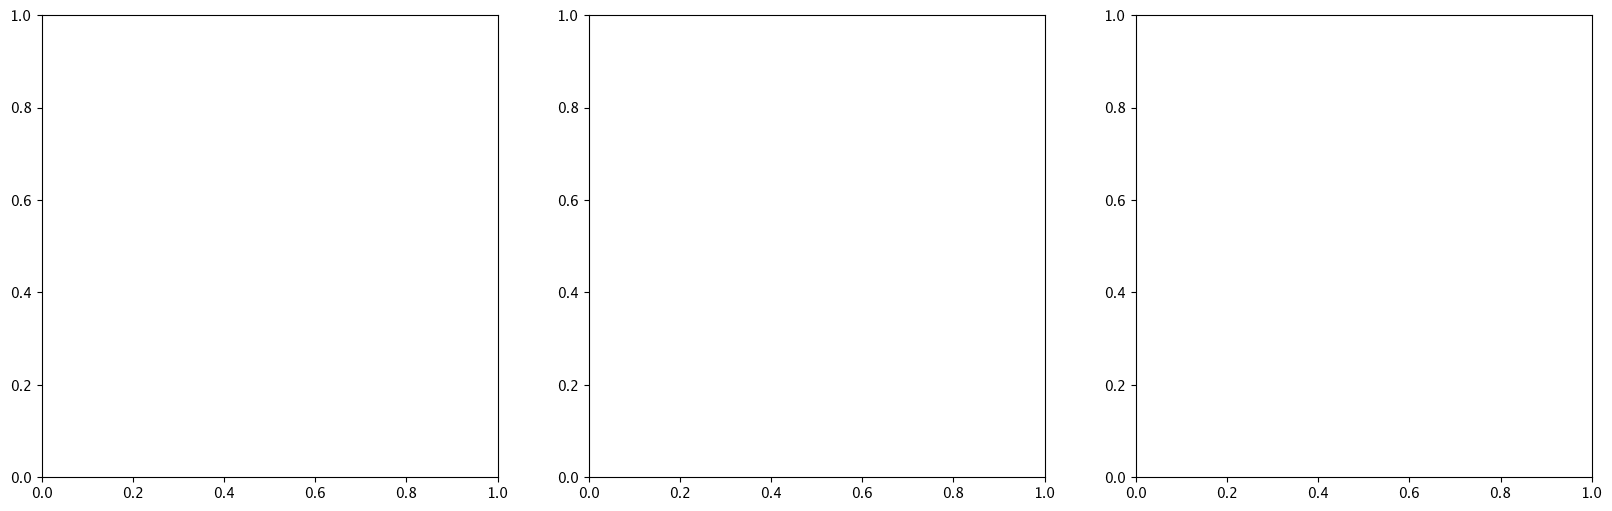

In [67]:
MetricsProcessing().evaluate_model(model,train_data.toarray(),train_target,test_data.toarray(),test_target)

### ROC e avaliação dos modelos

# Conclusões

Por enquanto o melhor modelo entre eles, sem contar o XGBoost, parece ser a arvore de decisão.

Parece valer a pena testar a vetorização com por NILC quando testarmos regressão.

Normalização da uma pequena melhora em alguns dos modelos, mas talvez seja por coincidencia (a seed ser boa para aquele novo formato de matriz especifica)